DataFrame:
   Obs  Fat  Salt Acceptance  Like  Dislike  Valor
0    1  0.2   0.9       like     1        0      1
1    2  0.1   0.1    dislike     0        1      0
2    3  0.2   0.4    dislike     0        1      0
3    4  0.2   0.5    dislike     0        1      0
4    5  0.4   0.5       like     1        0      1
5    6  0.3   0.8       like     1        0      1 

                            OLS Regression Results                            
Dep. Variable:                  Valor   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     4.726
Date:                Wed, 03 Sep 2025   Prob (F-statistic):              0.118
Time:                        20:04:56   Log-Likelihood:              -0.084776
No. Observations:                   6   AIC:                             6.170
Df Residuals:                       3   BIC:                             5.54

c:\Proyectos\PythonML\Clase\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


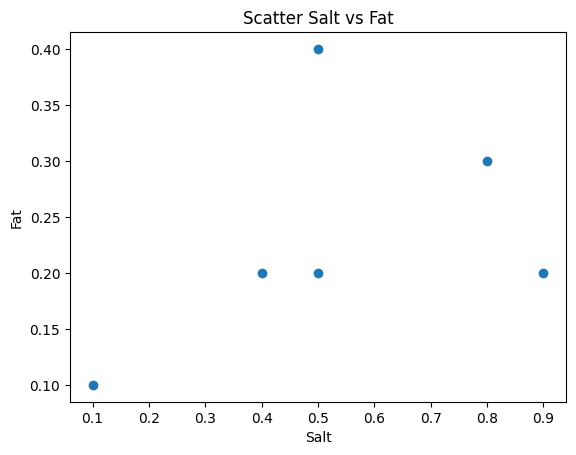


Regresión logística (sin capa oculta):
Coeficientes: [[0.54130976 0.18895371]] Intercepto: [-0.33288511]
Predicciones (0=dislike, 1=like): [1, 0, 0, 0, 1, 1]
MLPClassifier entrenado.
[9.99999997e-01 5.81543650e-11 2.44522579e-09 4.92821769e-04
 9.99403501e-01 9.99999997e-01]

MLP (capa oculta de 3):
Predicciones (0=dislike, 1=like): [1, 0, 0, 0, 1, 1]

Matriz de confusión (filas: verdadero, columnas: predicho) [dislike, like]:
 [[3 0]
 [0 3]]

Reporte de clasificación:
               precision    recall  f1-score   support

     dislike       1.00      1.00      1.00         3
        like       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelos
import statsmodels.api as sm                    # Para OLS y resumen tipo R
#pip install statsmodels patsy numpy scipy pandas
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Datos (equivalentes al R)
# -----------------------------
Obs = np.arange(1, 7)
Fat = np.array([0.2, 0.1, 0.2, 0.2, 0.4, 0.3])
Salt = np.array([0.9, 0.1, 0.4, 0.5, 0.5, 0.8])
Acceptance = np.array(['like', 'dislike', 'dislike', 'dislike', 'like', 'like'])

Like = (Acceptance == 'like')
Dislike = (Acceptance == 'dislike')

df = pd.DataFrame({
    'Obs': Obs,
    'Fat': Fat,
    'Salt': Salt,
    'Acceptance': Acceptance,
    'Like': Like.astype(int),        # 1 si like, 0 si no
    'Dislike': Dislike.astype(int)   # 1 si dislike, 0 si no
})

# En R: df$Valor <- df$Acceptance == 'like'
# En Python lo añadimos igual (como 0/1 para modelos)
df['Valor'] = (df['Acceptance'] == 'like').astype(int)

print("DataFrame:")
print(df, "\n")

# -----------------------------
# 1) Regresión lineal (OLS) Valor ~ Salt + Fat
#    (similar a lm en R; aquí Valor es 0/1)
# -----------------------------
X = df[['Salt', 'Fat']]
X = sm.add_constant(X)  # añade intercepto
y = df['Valor']

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

# Predicción sobre el propio df
y_pred_ols = ols_model.predict(X)
df['y_pred_ols'] = y_pred_ols

# -----------------------------
# 2) Scatter Salt vs Fat (como plot(Salt, Fat) en R)
# -----------------------------
plt.figure()
plt.scatter(df['Salt'], df['Fat'])
plt.xlabel('Salt')
plt.ylabel('Fat')
plt.title('Scatter Salt vs Fat')
plt.show()

# -----------------------------
# 3) "neuralnet hidden=0" ~ Regresión logística binaria
#    (sin capa oculta -> equivalente a una logística)
# -----------------------------
logreg = LogisticRegression()
logreg.fit(df[['Salt', 'Fat']], df['Like'])  # target = Like (0/1)
log_proba = logreg.predict_proba(df[['Salt', 'Fat']])[:, 1]
log_pred = (log_proba >= 0.5).astype(int)

print("\nRegresión logística (sin capa oculta):")
print("Coeficientes:", logreg.coef_, "Intercepto:", logreg.intercept_)
print("Predicciones (0=dislike, 1=like):", log_pred.tolist())

# -----------------------------
# 4) Red neuronal MLP (hidden=3, activación logística)
#    Similar a neuralnet(Like+Dislike ~ Salt + Fat, hidden=3)
#    Aquí usamos una sola salida binaria (Like) con activación logística.
# -----------------------------
mlp = MLPClassifier(hidden_layer_sizes=(3,),
                    activation='logistic',
                    solver='lbfgs',   # mejor para datasets pequeños
                    alpha=1e-5,   # menos regularización
                    max_iter=5000,
                    random_state=42)

mlp.fit(df[['Salt', 'Fat']], df['Like'])
print("MLPClassifier entrenado.")
mlp_proba = mlp.predict_proba(df[['Salt', 'Fat']])[:, 1]
print(mlp_proba)
mlp_pred = (mlp_proba >= 0.5).astype(int)

print("\nMLP (capa oculta de 3):")
print("Predicciones (0=dislike, 1=like):", mlp_pred.tolist())

# -----------------------------
# 5) Matriz de confusión y métricas (estilo caret::confusionMatrix)
# -----------------------------
# Para “predicted.class=apply(... which.max)-1” y luego mapear a dislike/like,
# en binario usamos 0/1 y luego convertimos a etiquetas.
pred_labels = np.where(mlp_pred == 1, 'like', 'dislike')
true_labels = df['Acceptance']

cm = confusion_matrix(true_labels, pred_labels, labels=['dislike','like'])
print("\nMatriz de confusión (filas: verdadero, columnas: predicho) [dislike, like]:\n", cm)
print("\nReporte de clasificación:\n", classification_report(true_labels, pred_labels, target_names=['dislike','like']))